In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

print(DEVICE)


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

cuda


In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.00MB/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [ ]:
print(len(train_dataset))

60000


In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

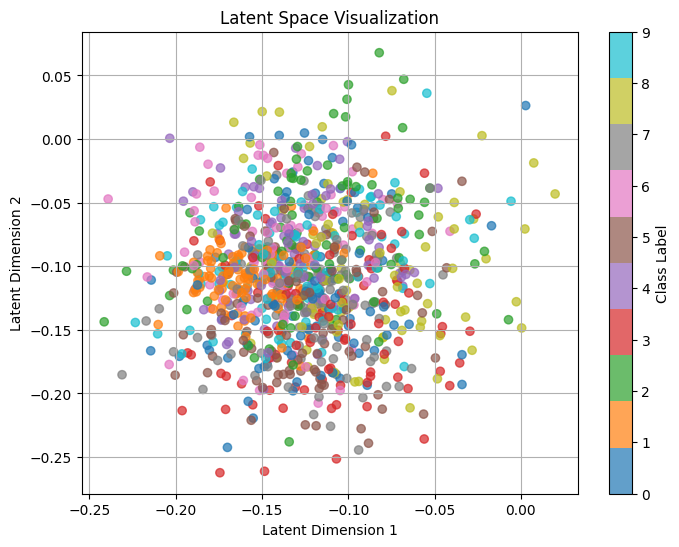

In [ ]:
# Load MNIST
def load_mnist(samples=1000):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(mnist, batch_size=samples, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.view(images.size(0), -1)  # Flatten 28x28 images into vectors of size 784
    return images, labels

# Visualize Latent Space
def visualize_latent_space_torch(encoder, X, y, latent_dim=200):
    encoder.eval()
    with torch.no_grad():
        means, _ = encoder(X)  # Encode the data
    latent_space = means.numpy().T

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_space[0], latent_space[1], c=y.numpy(), cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, label="Class Label")
    plt.title("Latent Space Visualization")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()


input_dim = 784
hidden_dim = 400
latent_dim = 200
samples = 1000
classes = 10

# Initialize Encoder
encoder = Encoder(input_dim, hidden_dim, latent_dim)

# Load MNIST Data
X, y = load_mnist(samples)

# Visualize
visualize_latent_space_torch(encoder, X, y)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # Sampling epsilon
        z = mean + var*epsilon                          # Reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # Takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.22755117578777
	Epoch 2 complete! 	Average Loss:  129.34117529867487
	Epoch 3 complete! 	Average Loss:  117.43878384547162
	Epoch 4 complete! 	Average Loss:  112.89552990335454
	Epoch 5 complete! 	Average Loss:  110.33109177731114
	Epoch 6 complete! 	Average Loss:  108.634290924327
	Epoch 7 complete! 	Average Loss:  107.31286874608723
	Epoch 8 complete! 	Average Loss:  106.2379904332742
	Epoch 9 complete! 	Average Loss:  105.4241609877139
	Epoch 10 complete! 	Average Loss:  104.79958946877609
	Epoch 11 complete! 	Average Loss:  104.29071377099854
	Epoch 12 complete! 	Average Loss:  103.8291457442091
	Epoch 13 complete! 	Average Loss:  103.3933280402233
	Epoch 14 complete! 	Average Loss:  103.09216682752505
	Epoch 15 complete! 	Average Loss:  102.80548366744053
	Epoch 16 complete! 	Average Loss:  102.48561800592132
	Epoch 17 complete! 	Average Loss:  102.26510528615401
	Epoch 18 complete! 	Average Loss:  102.01961079337958
	Ep

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

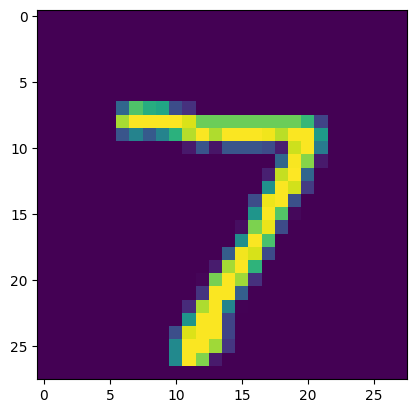

In [ ]:
show_image(x, idx=0)

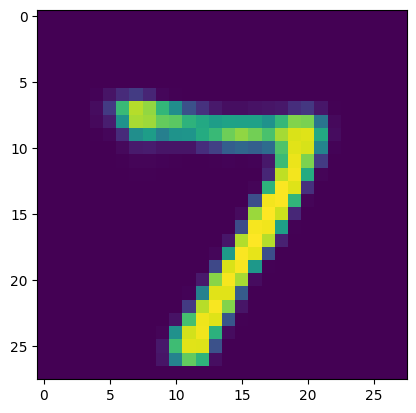

In [ ]:

show_image(x_hat, idx=0)

In [ ]:
def visualize_reconstructions(encoder, decoder, data_loader, device, n_samples=10):

    encoder.eval()
    decoder.eval()


    for batch in data_loader:
        x, _ = batch
        x = x.view(x.size(0), -1).to(device)
        break

    # Encode and decode data
    with torch.no_grad():
        mean, log_var = encoder(x)
        latent = mean  # Get latent vector
        x_hat = decoder(latent)  # Reconstruction image


    x = x.cpu().view(-1, 28, 28).numpy()
    x_hat = x_hat.cpu().view(-1, 28, 28).numpy()

    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))

    for i in range(n_samples):

        axes[0, i].imshow(x[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")


        axes[1, i].imshow(x_hat[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
    plt.tight_layout()
    plt.show()


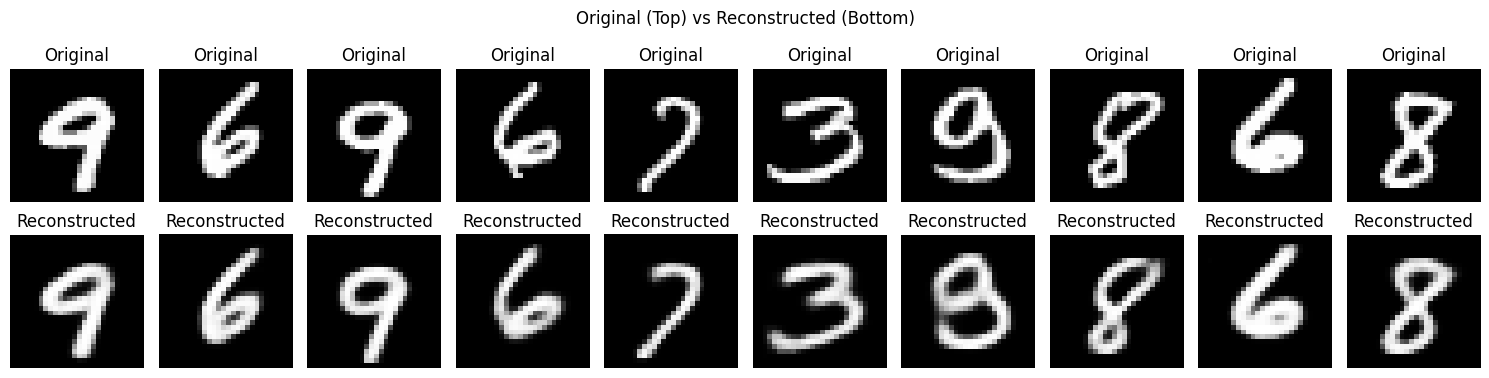

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
data_loader = DataLoader(mnist, batch_size=32, shuffle=True)


visualize_reconstructions(encoder, decoder, data_loader, device, n_samples=10)

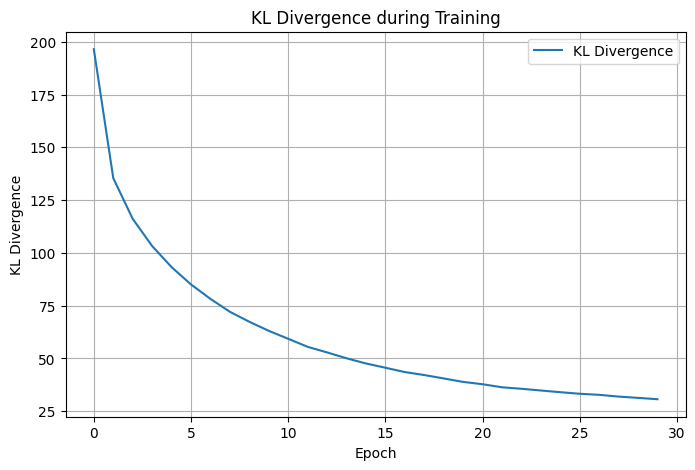

In [ ]:
# Visualize KL_losses during train
kl_losses = []


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_kl_loss = 0
    for batch in data_loader:
        x, _ = batch
        x = x.view(x.size(0), -1).to(device)

        optimizer.zero_grad()
        mean, log_var = encoder(x)
        latent = mean
        x_hat = decoder(latent)

        # Loss
        reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss = reconstruction_loss + KLD

        loss.backward()
        optimizer.step()

        epoch_kl_loss += KLD.item()

    kl_losses.append(epoch_kl_loss / len(data_loader))

# Draw KL divergence
def plot_kl_divergence(kl_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(kl_losses, label="KL Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("KL Divergence")
    plt.title("KL Divergence during Training")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_kl_divergence(kl_losses)

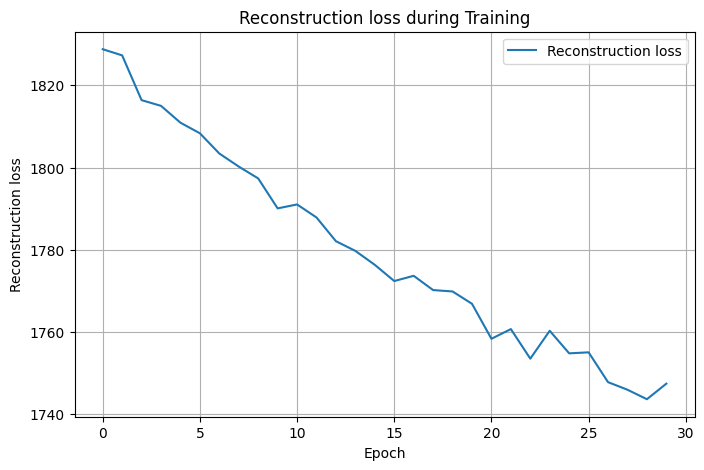

In [ ]:
# Visualize reconstruction_losses during train
reconstruction_losses = []


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_reconstruction_loss = 0
    for batch in data_loader:
        x, _ = batch
        x = x.view(x.size(0), -1).to(device)

        optimizer.zero_grad()
        mean, log_var = encoder(x)
        latent = mean
        x_hat = decoder(latent)

        # Loss
        reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss = reconstruction_loss + kl_loss

        loss.backward()
        optimizer.step()

        epoch_reconstruction_loss += reconstruction_loss.item()

    reconstruction_losses.append(epoch_reconstruction_loss / len(data_loader))

# Draw reconstruction loss
def plot_reconstruction(reconstruction_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(reconstruction_losses, label="Reconstruction loss")
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction loss")
    plt.title("Reconstruction loss during Training")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_reconstruction(reconstruction_losses)

# Câu 1 : Monte Carlo được thực hiện trong code như thế nào ?
Monte Carlo thực hiện hóa xuất hiện ở hai phần chính:

### **Sampling  từ :**

Được thực hiện thông qua Reparameterization Trick:

```cpp
def reparameterization(self, mean, var):
    epsilon = torch.randn_like(var).to(DEVICE)  # Lấy mẫu từ N(0, I)
    z = mean + var * epsilon                    # Reparameterization trick
    return z
```
Đây là cách lấy mẫu  từ  để đảm bảo gradient khả vi.

### **Ước lượng ELBO (Loss Function):**

Kỳ vọng trong ELBO được ước lượng với một mẫu  từ :
```cpp
reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
loss = reconstruction_loss + KLD
```
Monte Carlo được dùng để xấp xỉ  bằng một mẫu duy nhất .

# Câu 2 : Giải thích tại sao trong code dùng `log_var` thay vì `var`

Trong code, việc sử dụng `log_var` thay vì trực tiếp dùng `var` (phương sai) có những lý do chính sau:

---

### 1. Tính ổn định số học (Numerical Stability)

Phương sai $\sigma^2$ luôn có giá trị dương, nhưng trong quá trình tính toán hoặc tối ưu hóa, các giá trị rất nhỏ hoặc rất lớn của $\sigma^2$ có thể gây ra:

- **Overflow**: Khi $\sigma^2$ quá lớn.
- **Underflow**: Khi $\sigma^2$ quá nhỏ.

Sử dụng log (sigma^2) (logarithm của phương sai) đưa giá trị về một khoảng ổn định hơn, giúp giảm thiểu các vấn đề trên trong tính toán số học.

---

### 2. Gradient dễ tính hơn trong quá trình huấn luyện

Khi sử dụng $\text{log_var}$, việc tính toán và lan truyền gradient trở nên thuận lợi hơn. Cụ thể:

- $\text{log_var} = \log(\sigma^2)$ cho phép biểu diễn:
  $$
  \sigma^2 = \exp(\text{log\_var}).
  $$
- Đạo hàm theo $\text{log_var} )$ trở nên ổn định hơn, vì hàm $\exp(\cdot)$ luôn khả vi và không gặp vấn đề với giá trị âm.

---

### 3. Thuận lợi trong công thức KL Divergence

Phần KL Divergence trong ELBO được tính bằng công thức:

$$
\text{KLD} = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right).
$$

- Việc lưu trữ $\log \sigma^2$ sẵn (dưới dạng `log_var`) sẽ giảm bớt một phép tính $\log(\cdot)$ khi tính KL Divergence.
- Điều này giúp tiết kiệm thời gian tính toán và tránh sai số do phép tính log trên các giá trị rất nhỏ.

---

### 4. Hỗ trợ Reparameterization Trick

Trong bước tái tham số hóa, ta cần tính:

$$
z = \mu + \sigma \cdot \epsilon,
$$

với $\sigma$ được tính từ $\text{log_var}$ thông qua:

$$
\sigma = \exp\left(0.5 \cdot \text{log_var}\right).
$$

- Sử dụng $\text{log_var}$ giúp đảm bảo rằng $\sigma$ luôn dương (nhờ hàm $ \exp$, tránh các lỗi khi tính toán nếu $\sigma$ được lấy trực tiếp từ $ \text{var}$

---
